In [1]:
# Cell 1: install (if needed) and imports
# Uncomment to install xgboost if not present:
# !pip install -q xgboost

import os, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import joblib
import xgboost as xgb

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,5)
RSEED = 42
np.random.seed(RSEED)
os.makedirs("output/models", exist_ok=True)


In [2]:
# Cell 2: load dataset (adjust path if different)
DATA_PATH = r"C:\Users\KIIT\Desktop\RoadAccidentAnalysis\RoadAccidentsInIndia\ML_Integration\output\per_year_csvs\accidents_2015_2025_all_states_zones_combined.csv"
assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
print("Loaded rows:", df.shape[0], "columns:", df.shape[1])
display(df.head())
display(df.describe(include='all').T)


Loaded rows: 1980 columns: 26


,Sl No.,year,State,zone,region,state_population_zone,registered_vehicles_zone,road_length_km,road_condition,avg_speed_index,...,enforcement_index,health_index,urban_flag,traffic_density,time_to_hospital,monthality_index,danger_score,no_of_accidents,no_of_injured,no_of_killed
0,1,2015,Andhra Pradesh,Andhra Pradesh_Zone1,south,11779429,316201,12757,dirt road,40.14,...,0.611,0.578,0,18.343,60.70,0.000,0.7896,57090,98859,995
1,2,2015,Andhra Pradesh,Andhra Pradesh_Zone2,south,14265254,150787,8202,proper road,59.64,...,0.569,0.617,1,7.087,45.92,0.083,0.4835,17764,32397,311
2,3,2015,Andhra Pradesh,Andhra Pradesh_Zone3,south,15023427,212094,6441,proper road,32.24,...,0.779,0.682,0,9.668,45.85,0.167,0.9334,34749,56972,587
3,4,2015,Andhra Pradesh,Andhra Pradesh_Zone4,south,11927515,177673,13759,proper road,48.26,...,0.621,0.645,1,18.306,42.61,0.250,0.4382,23751,39199,409
4,5,2015,Andhra Pradesh,Andhra Pradesh_Zone5,south,16897074,249438,8604,proper road,50.21,...,0.588,0.605,0,17.909,56.81,0.333,0.4821,24604,43436,437


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Sl No.,1980.0,NaN,NaN,NaN,990.5,571.721086,1.0,495.75,990.5,1485.25,1980.0
year,1980.0,NaN,NaN,NaN,2020.0,3.163077,2015.0,2017.0,2020.0,2023.0,2025.0
State,1980,36,Andhra Pradesh,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zone,1980,180,Andhra Pradesh_Zone1,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1980,6,north,495,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state_population_zone,1980.0,NaN,NaN,NaN,11799302.40101,6947018.445161,1636848.0,6316986.5,10669495.5,16073106.5,34704125.0
registered_vehicles_zone,1980.0,NaN,NaN,NaN,135260.14697,75806.025677,8142.0,77897.25,126687.5,188680.25,332180.0
road_length_km,1980.0,NaN,NaN,NaN,11582.513636,6367.188866,1128.0,6536.5,10671.5,15832.75,29274.0
road_condition,1980,3,proper road,1082,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_speed_index,1980.0,NaN,NaN,NaN,62.020379,18.676276,30.0,46.3925,61.735,78.335,94.91


In [3]:
# Cell 3: prepare features & targets
df = df.copy()
df["year_since_2015"] = df["year"] - df["year"].min()

# Feature columns (original + engineered from generator)
feature_cols = [
    "State","zone","region","year_since_2015",
    "state_population_zone","registered_vehicles_zone","road_length_km",
    "road_condition","avg_speed_index","overspeeding","bad_weather",
    "fault_of_driver","driver_below_18","fault_in_vehicle",
    "pct_two_wheelers","enforcement_index","health_index","urban_flag",
    "traffic_density","time_to_hospital","monthality_index","danger_score"
]

# Targets
target_cols = ["no_of_accidents","no_of_injured","no_of_killed"]

# Ensure booleans/numerics are correct dtype
for b in ["overspeeding","bad_weather","fault_of_driver","driver_below_18","fault_in_vehicle","urban_flag"]:
    df[b] = df[b].astype(int)

X = df[feature_cols].copy()
y = df[target_cols].copy()

print("X shape:", X.shape, "y shape:", y.shape)
display(X.head())


X shape: (1980, 22) y shape: (1980, 3)


,State,zone,region,year_since_2015,state_population_zone,registered_vehicles_zone,road_length_km,road_condition,avg_speed_index,overspeeding,...,driver_below_18,fault_in_vehicle,pct_two_wheelers,enforcement_index,health_index,urban_flag,traffic_density,time_to_hospital,monthality_index,danger_score
0,Andhra Pradesh,Andhra Pradesh_Zone1,south,0,11779429,316201,12757,dirt road,40.14,0,...,0,0,0.300,0.611,0.578,0,18.343,60.70,0.000,0.7896
1,Andhra Pradesh,Andhra Pradesh_Zone2,south,0,14265254,150787,8202,proper road,59.64,0,...,0,0,0.260,0.569,0.617,1,7.087,45.92,0.083,0.4835
2,Andhra Pradesh,Andhra Pradesh_Zone3,south,0,15023427,212094,6441,proper road,32.24,0,...,0,0,0.280,0.779,0.682,0,9.668,45.85,0.167,0.9334
3,Andhra Pradesh,Andhra Pradesh_Zone4,south,0,11927515,177673,13759,proper road,48.26,0,...,0,0,0.275,0.621,0.645,1,18.306,42.61,0.250,0.4382
4,Andhra Pradesh,Andhra Pradesh_Zone5,south,0,16897074,249438,8604,proper road,50.21,0,...,1,0,0.598,0.588,0.605,0,17.909,56.81,0.333,0.4821


In [4]:
# Cell 4: time-based split
train_mask = df["year"] <= 2023
test_mask  = df["year"] >= 2024

X_train = X[train_mask].reset_index(drop=True)
X_test  = X[test_mask].reset_index(drop=True)
y_train = y[train_mask].reset_index(drop=True)
y_test  = y[test_mask].reset_index(drop=True)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (1620, 22) Test shape: (360, 22)


In [5]:
# Cell 5: preprocessing and model pipelines
cat_cols = ["State","zone","region","road_condition"]
# numeric columns are all others in feature_cols but not in cat
num_cols = [c for c in feature_cols if c not in cat_cols]

preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ("num", StandardScaler(), num_cols)
], remainder="drop")

# Models: Multi-output wrappers
pipe_rf = Pipeline([("pre", preprocessor),
                    ("model", MultiOutputRegressor(RandomForestRegressor(n_estimators=300, random_state=RSEED, n_jobs=-1)))])

pipe_xgb = Pipeline([("pre", preprocessor),
                     ("model", MultiOutputRegressor(xgb.XGBRegressor(n_estimators=300, random_state=RSEED, objective='reg:squarederror', n_jobs=4)))])

pipe_lr = Pipeline([("pre", preprocessor),
                    ("model", MultiOutputRegressor(LinearRegression()))])

print("Pipelines created.")


Pipelines created.


In [6]:
# Cell 6: train (may take a little time)
print("Training RandomForest...")
pipe_rf.fit(X_train, y_train)
print("Training XGBoost...")
pipe_xgb.fit(X_train, y_train)
print("Training Linear Regression...")
pipe_lr.fit(X_train, y_train)

# Save pipelines
joblib.dump(pipe_rf, "output/models/pipe_rf.joblib")
joblib.dump(pipe_xgb, "output/models/pipe_xgb.joblib")
joblib.dump(pipe_lr, "output/models/pipe_lr.joblib")
print("Training finished. Models saved to output/models/")


Training RandomForest...
Training XGBoost...
Training Linear Regression...
Training finished. Models saved to output/models/


In [7]:
# Cell 7: evaluation helpers and metrics
def mape(y_true, y_pred):
    # handle zeros
    y_t = np.array(y_true, dtype=float)
    y_p = np.array(y_pred, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        m = np.abs((y_t - y_p) / np.where(y_t == 0, 1e-9, y_t))
    return np.mean(m) * 100

def eval_multi(y_true_df, y_pred_arr):
    names = ["no_of_accidents","no_of_injured","no_of_killed"]
    rows = []
    for i,name in enumerate(names):
        y_t = y_true_df.iloc[:, i].values
        y_p = y_pred_arr[:, i]
        mae = mean_absolute_error(y_t, y_p)
        rmse = math.sqrt(mean_squared_error(y_t, y_p))
        r2 = r2_score(y_t, y_p)
        mape_v = mape(y_t, y_p)
        rows.append({"target": name, "mae": mae, "rmse": rmse, "r2": r2, "mape_pct": mape_v})
    return pd.DataFrame(rows)

y_pred_rf  = pipe_rf.predict(X_test)
y_pred_xgb = pipe_xgb.predict(X_test)
y_pred_lr  = pipe_lr.predict(X_test)

metrics_rf  = eval_multi(y_test, y_pred_rf)
metrics_xgb = eval_multi(y_test, y_pred_xgb)
metrics_lr  = eval_multi(y_test, y_pred_lr)

print("Random Forest metrics:"); display(metrics_rf)
print("XGBoost metrics:"); display(metrics_xgb)
print("Linear Regression metrics:"); display(metrics_lr)


Random Forest metrics:


,target,mae,rmse,r2,mape_pct
0,no_of_accidents,39579.092139,187879.800493,0.514330,21.369637
1,no_of_injured,111696.870120,504197.095288,0.526623,23.301016
2,no_of_killed,4163.984676,19487.504013,0.554882,31.093526


XGBoost metrics:


,target,mae,rmse,r2,mape_pct
0,no_of_accidents,35930.609375,171682.090574,0.594463,19.911915
1,no_of_injured,102084.609375,468153.136245,0.591885,21.580998
2,no_of_killed,3796.555664,17693.280985,0.633073,34.599134


Linear Regression metrics:


,target,mae,rmse,r2,mape_pct
0,no_of_accidents,58288.928784,205763.210200,0.417473,90.553211
1,no_of_injured,172914.166596,571816.885997,0.391136,140.539145
2,no_of_killed,7429.635774,24106.824610,0.318850,513.107512


In [8]:
# Cell 8: combined comparison
metrics_rf["model"] = "RandomForest"
metrics_xgb["model"] = "XGBoost"
metrics_lr["model"] = "LinearRegression"
cmp_df = pd.concat([metrics_rf, metrics_xgb, metrics_lr], ignore_index=True)
cmp_df = cmp_df[["model","target","r2","mae","rmse","mape_pct"]]
display(cmp_df.sort_values(["target","r2"], ascending=[True, False]).reset_index(drop=True))


,model,target,r2,mae,rmse,mape_pct
0,XGBoost,no_of_accidents,0.594463,35930.609375,171682.090574,19.911915
1,RandomForest,no_of_accidents,0.514330,39579.092139,187879.800493,21.369637
2,LinearRegression,no_of_accidents,0.417473,58288.928784,205763.210200,90.553211
3,XGBoost,no_of_injured,0.591885,102084.609375,468153.136245,21.580998
4,RandomForest,no_of_injured,0.526623,111696.870120,504197.095288,23.301016
5,LinearRegression,no_of_injured,0.391136,172914.166596,571816.885997,140.539145
6,XGBoost,no_of_killed,0.633073,3796.555664,17693.280985,34.599134
7,RandomForest,no_of_killed,0.554882,4163.984676,19487.504013,31.093526
8,LinearRegression,no_of_killed,0.318850,7429.635774,24106.824610,513.107512


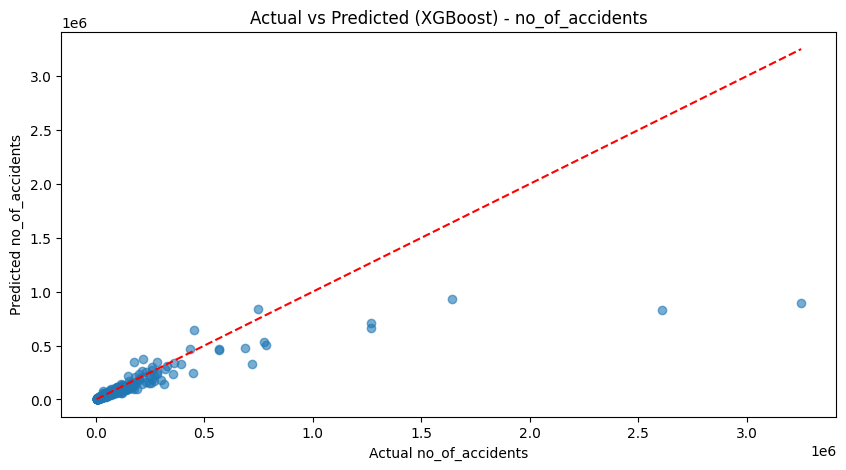

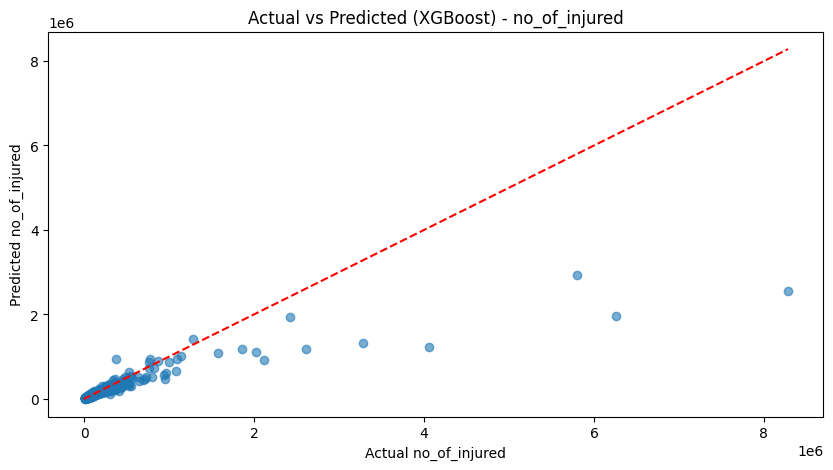

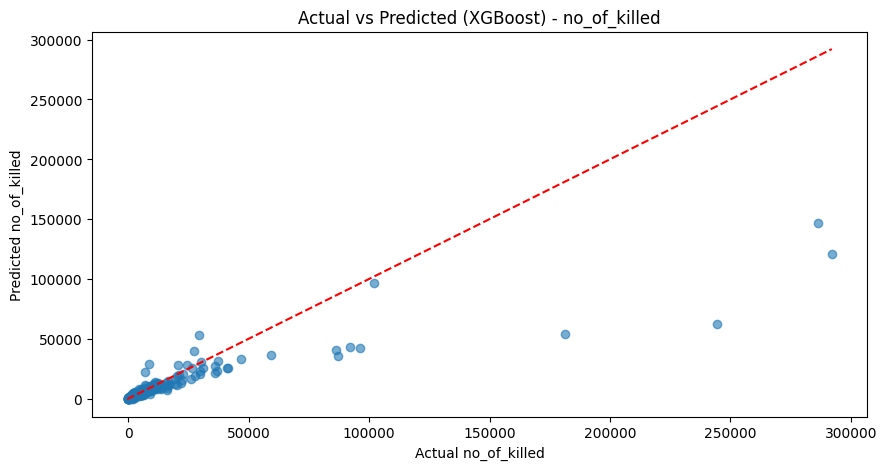

In [9]:
# Cell 9: Actual vs Predicted scatter plots for XGBoost
best_pred = y_pred_xgb  # change to y_pred_rf if RF was best
targets = ["no_of_accidents","no_of_injured","no_of_killed"]
for i,t in enumerate(targets):
    plt.figure()
    plt.scatter(y_test[t], best_pred[:,i], alpha=0.6)
    mn = min(y_test[t].min(), best_pred[:,i].min())
    mx = max(y_test[t].max(), best_pred[:,i].max())
    plt.plot([mn,mx],[mn,mx],"r--")
    plt.xlabel("Actual "+t); plt.ylabel("Predicted "+t)
    plt.title("Actual vs Predicted (XGBoost) - "+t)
    plt.show()


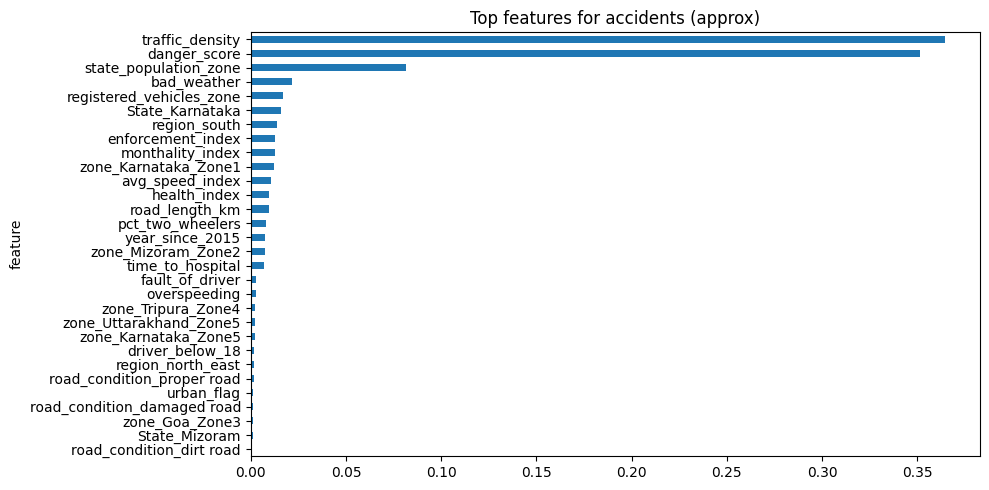

,feature,importance
239,traffic_density,0.364728
242,danger_score,0.351502
226,state_population_zone,0.081270
231,bad_weather,0.021476
227,registered_vehicles_zone,0.016970
15,State_Karnataka,0.015860
220,region_south,0.013792
236,enforcement_index,0.012968
241,monthality_index,0.012541
111,zone_Karnataka_Zone1,0.012060


In [10]:
# Cell 10: approximate feature importance for accidents
# transform X_train using preprocessor to numeric matrix
pre = pipe_rf.named_steps["pre"]
X_train_trans = pre.transform(X_train)
cat_feature_names = pre.named_transformers_["cat"].get_feature_names_out(cat_cols).tolist()
num_feature_names = num_cols
feature_names = list(cat_feature_names) + list(num_feature_names)

# single-output RF for importances
from sklearn.ensemble import RandomForestRegressor as RFR_single
rf_single = RFR_single(n_estimators=300, random_state=RSEED)
rf_single.fit(X_train_trans, y_train["no_of_accidents"])
importances = rf_single.feature_importances_
imp_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False).head(30)
imp_df.plot.barh(x="feature", y="importance", legend=False)
plt.gca().invert_yaxis()
plt.title("Top features for accidents (approx)")
plt.tight_layout()
plt.show()
display(imp_df)


In [11]:
# Cell 11: save metrics and test predictions
cmp_df.to_csv("output/models_metrics_comparison.csv", index=False)

preds_xgb_df = pd.DataFrame(best_pred, columns=["pred_accidents","pred_injured","pred_killed"])
preds_xgb_df = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True), preds_xgb_df], axis=1)
preds_xgb_df.to_csv("output/test_predictions_xgb.csv", index=False)
print("Saved metrics and predictions under output/")


Saved metrics and predictions under output/


Future Predictions (2026-2028):


,year,pred_accidents,pred_injured,pred_killed
0,2026,72831963,288811377,9010614
1,2027,70131404,289789993,8261602
2,2028,65408357,250930243,7481188


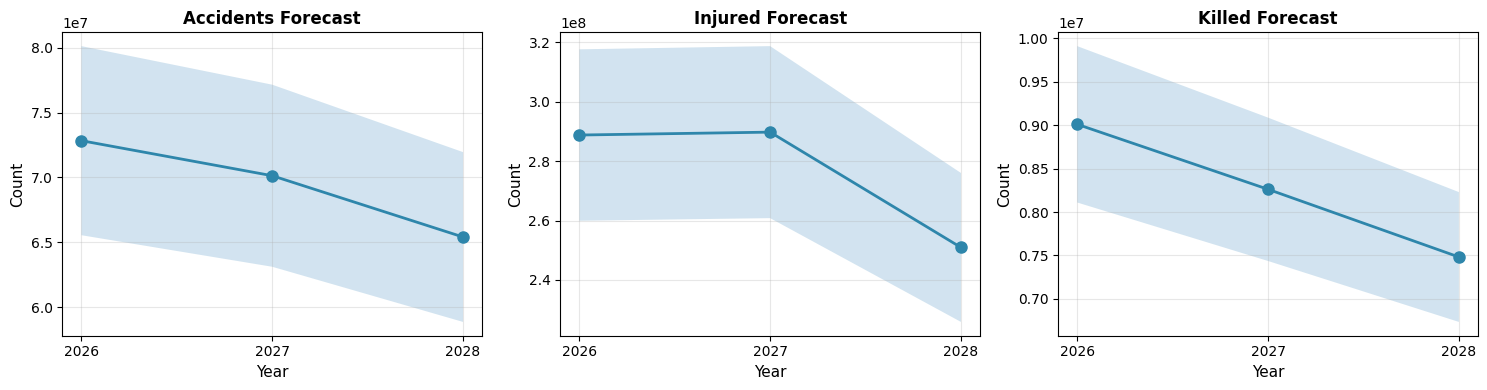

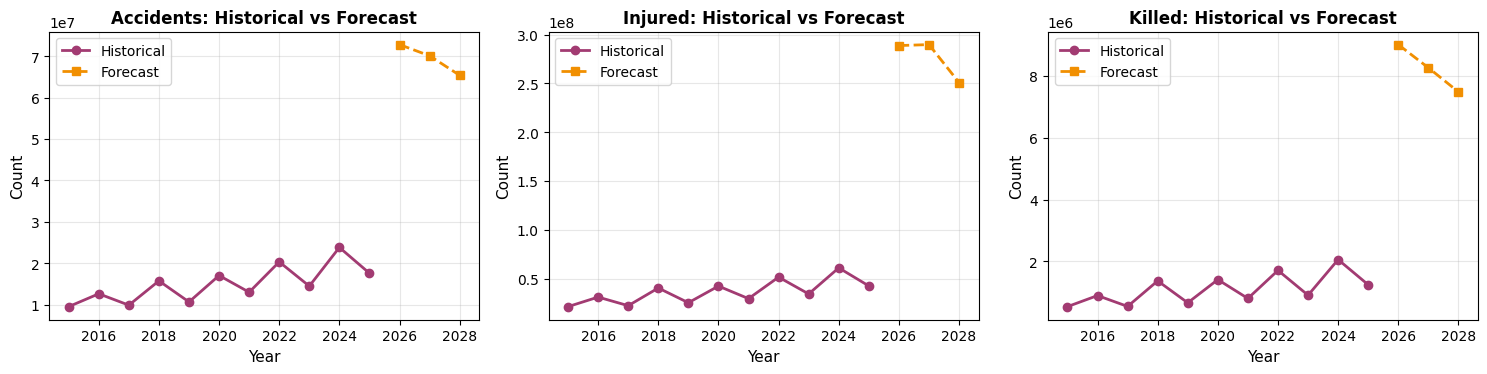


Future predictions saved to output/


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Cell 12: Generate future predictions for 2026-2028 and visualize trends

# Ensure output folder exists
os.makedirs("output", exist_ok=True)

# Derive 'states' and base values from existing data if not already defined
if 'states' in globals():
    states = states
else:
    if 'df' in globals():
        states = sorted(df['State'].unique())
    elif 'X_test' in globals():
        states = sorted(X_test['State'].unique())
    else:
        raise NameError("Cannot infer 'states'. Define a 'states' list or ensure 'df' or 'X_test' is available in the notebook.")

# zones_per_state fallback (use 5 if not defined)
zones_per_state = globals().get('zones_per_state', 5)

# Choose a source DataFrame to compute base values (prefer df then X_train/X_test)
source_df = None
for candidate in ('df', 'X_train', 'X_test', 'preds_xgb_df'):
    if candidate in globals():
        source_df = globals()[candidate]
        break
if source_df is None:
    raise NameError("Cannot infer base values: 'df', 'X_train', 'X_test' or 'preds_xgb_df' must be present.")

# Compute base dictionaries (mean per state) for population, vehicles and road length
state_population_base = source_df.groupby('State')['state_population_zone'].mean().to_dict()
state_vehicles_base = source_df.groupby('State')['registered_vehicles_zone'].mean().to_dict()
state_roadlength_base = source_df.groupby('State')['road_length_km'].mean().to_dict()

# Helper to get region for a state
def get_region(state):
    if 'df' in globals():
        rows = df[df['State'] == state]
    elif 'X_test' in globals():
        rows = X_test[X_test['State'] == state]
    else:
        rows = source_df[source_df['State'] == state]
    if len(rows):
        return rows['region'].iloc[0]
    return 'unknown'

# Create future scenarios for 2026-2028
future_years = [2026, 2027, 2028]
future_predictions = []

# Use existing test data structure to create future data
for year in future_years:
    for state in states:
        for z in range(1, zones_per_state + 1):
            # Create a sample row based on patterns from existing data
            zone_name = f"{state}_Zone{z}"
            region = get_region(state)
            
            # Use base values and apply temporal trend / randomness
            pop = int(state_population_base.get(state, np.mean(list(state_population_base.values()))) / zones_per_state * np.random.uniform(0.6, 1.4))
            vehicles = int(state_vehicles_base.get(state, np.mean(list(state_vehicles_base.values()))) / zones_per_state * np.random.uniform(0.6, 1.6))
            road_len = int(state_roadlength_base.get(state, np.mean(list(state_roadlength_base.values()))) / zones_per_state * np.random.uniform(0.5, 1.5))
            
            # Create feature row for prediction
            feature_row = {
                "State": state,
                "zone": zone_name,
                "region": region,
                "year_since_2015": year - 2015,
                "state_population_zone": pop,
                "registered_vehicles_zone": vehicles,
                "road_length_km": road_len,
                "road_condition": np.random.choice(["proper road", "dirt road", "damaged road"], p=[0.6, 0.25, 0.15]),
                "avg_speed_index": float(np.random.uniform(30, 95)),
                "overspeeding": np.random.choice([0, 1], p=[0.7, 0.3]),
                "bad_weather": np.random.choice([0, 1], p=[0.8, 0.2]),
                "fault_of_driver": np.random.choice([0, 1], p=[0.75, 0.25]),
                "driver_below_18": np.random.choice([0, 1], p=[0.95, 0.05]),
                "fault_in_vehicle": np.random.choice([0, 1], p=[0.88, 0.12]),
                "pct_two_wheelers": float(np.random.uniform(0.1, 0.8)),
                "enforcement_index": float(np.random.uniform(0.3, 0.9)),
                "health_index": float(np.random.uniform(0.3, 0.9)),
                "urban_flag": np.random.choice([0, 1], p=[0.5, 0.5]),
                "traffic_density": float(np.random.uniform(20, 300)),
                "time_to_hospital": float(np.random.uniform(5, 60)),
                "monthality_index": float(np.random.uniform(0, 1)),
                "danger_score": float(np.random.uniform(0.5, 3.0))
            }
            future_predictions.append(feature_row)

# Build DataFrame and predict using the trained pipeline
X_future = pd.DataFrame(future_predictions)
y_future_pred = pipe_xgb.predict(X_future)

# Aggregate predictions by year and state
future_results = []
for i in range(len(X_future)):
    future_results.append({
        "year": int(2015 + X_future.iloc[i]["year_since_2015"]),
        "state": X_future.iloc[i]["State"],
        "pred_accidents": int(y_future_pred[i, 0]),
        "pred_injured": int(y_future_pred[i, 1]),
        "pred_killed": int(y_future_pred[i, 2])
    })

future_df = pd.DataFrame(future_results)

# Aggregate by year
yearly_agg = future_df.groupby("year").agg({
    "pred_accidents": "sum",
    "pred_injured": "sum",
    "pred_killed": "sum"
}).reset_index()

print("Future Predictions (2026-2028):")
display(yearly_agg)

# Plot 1: Future trends
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
targets = ["pred_accidents", "pred_injured", "pred_killed"]
titles = ["Accidents Forecast", "Injured Forecast", "Killed Forecast"]

for idx, (target, title) in enumerate(zip(targets, titles)):
    axes[idx].plot(yearly_agg["year"], yearly_agg[target], marker='o', linewidth=2, markersize=8, color='#2E86AB')
    axes[idx].fill_between(yearly_agg["year"], yearly_agg[target] * 0.9, yearly_agg[target] * 1.1, alpha=0.2)
    axes[idx].set_xlabel("Year", fontsize=11)
    axes[idx].set_ylabel("Count", fontsize=11)
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xticks(yearly_agg["year"])

plt.tight_layout()
plt.show()

# Plot 2: Historical vs Future comparison
historical_yearly = df.groupby("year").agg({
    "no_of_accidents": "sum",
    "no_of_injured": "sum",
    "no_of_killed": "sum"
}).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
hist_target = ["no_of_accidents", "no_of_injured", "no_of_killed"]
pred_target = ["pred_accidents", "pred_injured", "pred_killed"]
titles = ["Accidents: Historical vs Forecast", "Injured: Historical vs Forecast", "Killed: Historical vs Forecast"]

for idx, (h_t, p_t, title) in enumerate(zip(hist_target, pred_target, titles)):
    axes[idx].plot(historical_yearly["year"], historical_yearly[h_t], marker='o', label='Historical', linewidth=2, color='#A23B72')
    axes[idx].plot(yearly_agg["year"], yearly_agg[p_t], marker='s', label='Forecast', linewidth=2, color='#F18F01', linestyle='--')
    axes[idx].set_xlabel("Year", fontsize=11)
    axes[idx].set_ylabel("Count", fontsize=11)
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save future predictions
future_df.to_csv("output/future_predictions_2026_2028.csv", index=False)
yearly_agg.to_csv("output/future_yearly_aggregated_2026_2028.csv", index=False)
print("\nFuture predictions saved to output/")

In [13]:
year=2032


In [14]:
# Create a DataFrame from test data with correct column names and shape
test_values = [
	'Odisha',                    # State
	'Odisha_Zone1',              # zone
	'east',                      # region
	year-2015,                          # year_since_2015
	17768079,                    # state_population_zone
	195981,                      # registered_vehicles_zone
	9492,                        # road_length_km
	'dirt road',                 # road_condition
	82.99,                       # avg_speed_index
	0,                           # overspeeding
	0,                           # bad_weather
	0,                           # fault_of_driver
	0,                           # driver_below_18
	0,                           # fault_in_vehicle
	0.161,                       # pct_two_wheelers
	0.488,                       # enforcement_index
	0.604,                       # health_index
	0,                           # urban_flag
	9.298,                       # traffic_density
	57.06,                       # time_to_hospital
	0.833,                       # monthality_index
	0.8333                       # danger_score
]

test_df = pd.DataFrame([test_values], columns=feature_cols)
prediction = pipe_xgb.predict(test_df)
type(prediction)


numpy.ndarray

In [15]:


print("year:",year)
print(test_values)
print("prediction: No. of Accidents")
print(prediction[0][0])

print("prediction:No. of Injured")
print(prediction[0][1])

print("prediction: No. of Killed")
print(prediction[0][2])


year: 2032
['Odisha', 'Odisha_Zone1', 'east', 17, 17768079, 195981, 9492, 'dirt road', 82.99, 0, 0, 0, 0, 0, 0.161, 0.488, 0.604, 0, 9.298, 57.06, 0.833, 0.8333]
prediction: No. of Accidents
31170.713
prediction:No. of Injured
83156.28
prediction: No. of Killed
608.2831
